In [1]:
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
data=pd.read_csv('simulation/simulation_tri_balance.csv')

In [11]:
data.describe(include='all')

,ytrue,ypred,method,alf,type,t,prec,alfstr
count,252000.000000,252000.000000,252000,252000.000000,201600,252000.000000,252000,252000
unique,NaN,NaN,7,NaN,4,NaN,2,7
top,NaN,NaN,LDAS,NaN,scad,NaN,True,alf=-1.0
freq,NaN,NaN,201600,NaN,50400,NaN,230861,50400
mean,0.500000,0.502440,NaN,-0.189867,NaN,1.500000,NaN,NaN
std,0.500001,0.499995,NaN,0.405351,NaN,0.908297,NaN,NaN
min,0.000000,0.000000,NaN,-1.000000,NaN,0.000000,NaN,NaN
25%,0.000000,0.000000,NaN,0.001000,NaN,0.750000,NaN,NaN
50%,0.500000,1.000000,NaN,0.005000,NaN,1.500000,NaN,NaN
75%,1.000000,1.000000,NaN,0.010000,NaN,2.250000,NaN,NaN


In [12]:
datas=data[data.method=='LDAS']

In [13]:
datas.head(10)

,ytrue,ypred,method,alf,type,t,prec,alfstr
0,0,0,LDAS,0.05,hard,0.0,True,alf=0.05
1,1,1,LDAS,0.05,hard,0.0,True,alf=0.05
2,0,0,LDAS,0.05,hard,0.0,True,alf=0.05
3,1,1,LDAS,0.05,hard,0.0,True,alf=0.05
4,0,1,LDAS,0.05,hard,0.0,False,alf=0.05
5,1,1,LDAS,0.05,hard,0.0,True,alf=0.05
6,0,0,LDAS,0.05,hard,0.0,True,alf=0.05
7,1,1,LDAS,0.05,hard,0.0,True,alf=0.05
8,0,0,LDAS,0.05,hard,0.0,True,alf=0.05
9,1,1,LDAS,0.05,hard,0.0,True,alf=0.05


In [14]:
np.unique(datas.alf)

array([0.001 , 0.0025, 0.005 , 0.0075, 0.01  , 0.05  ])

In [10]:
datas['alfstr']='alf='+datas.alf.astype('str')

in order to make alf recognized as factor by hue in seaborn, convert alf into string that unablt to be interpreted as numric

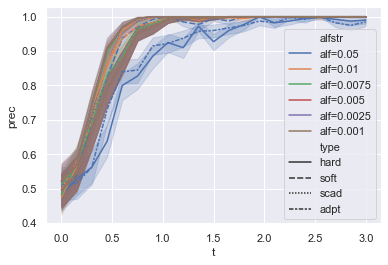

In [15]:
sns.set(style="darkgrid")
sns.lineplot(x="t", y="prec",
             hue="alfstr", style="type",
             data=datas)

In [28]:
data_method=data[(data.method!='LDAS')&(data.t<2)]

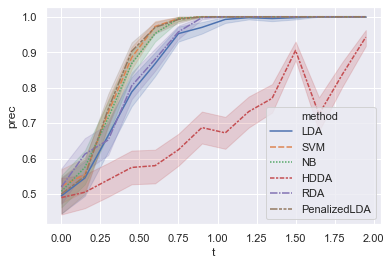

In [29]:
sns.lineplot(x="t", y="prec", hue='method',style="method",
             data=data_method)

In [16]:
data_method['method']

Series([], Name: method, dtype: object)